# Non-negative Matrix Factorization

## Recommender Systems and how Factorization arises
- a good recomemndation is a movie that user will rate highly
- recommendation list is a list of movies ordered by predicted rating
- our task: predict unknown ratings
- assumes we already have a dataset with ratings to learn from
- database tables are fine but we need to think a bit more abstracly to solve this problem
- The rating matrix is a more useful way to store ratings, M users in rows and N movies in cols (MxN)
- But this a matrix that most values are missing, thing how many thouasands movies there are
- It's a sparse matrix (different from tfidf: zero vs missing)
- goal: fill the missing values
### Matrix Factorization
- imagine that rating matrix is really a result of multiplying two smaller matrices
- R (MxN) = W(MxK) * H(KxN)
- Trick : when we multiply these two matrices together the result will be MxN matrix with no missing values
- How to find W and H?
- the way we "train" ML models is normally define a loss function; and then find the values of W and H that will minimize that loss
- When loss = KL-divergence, the model is latent semantic probabilistic analysis!
- What is KL-divergence ?? 

- Another discussion: why it works?
- we're assuming the true rank of R is K. bcz W and H are both rank K(since probably K is smaller than N and M)
- you can think of K as true number of hidden factos, or in this lecture the true number of hidden topics
#### Why non-negative ?
- W and H should only contain non-neg numbers as we know they will represent some topics , documents wikk contain non-negative number of topics n topics will contain non-neg number of words
### Why relevant for LDA?
- Recall LDA made up two matrices documentxtopics and topicsxwords
- this is exactly whan an NMF gives us
- if the input to our matrix factorization is a TFIDF matrix (document x words), topics will be hidden variable so as usual we'll choose our value, in the recommender analogy corresponds to K, the output will be exactly the same as LDA!

## Exercise:

In [1]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

File 'bbc_text_cls.csv' already there; not retrieving.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer #notice this time we'll use TFIDF
from sklearn.decomposition import NMF

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stops = set(stopwords.words('english'))

stops = stops.union({
    'said', 'would', 'could', 'told', 'also', 'one', 'two',
    'mr', 'new', 'year', 
})

In [6]:
df = pd.read_csv('bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [7]:
vectorizer = TfidfVectorizer(stop_words=stops)
X = vectorizer.fit_transform(df['text'])

# Note: you could potentially split the data into train and test
# and evaluate the model using the log-likelihood or perplexity
# on out-of-sample data

In [8]:
nmf = NMF(
    n_components=10, # default: 10 #we agai choose value K
    beta_loss="kullback-leibler", ### note that for the loss we use the KL-divergence, corresponds to 
    #probabilistic latent semantic analysis
    #note when you use this loss, it's required to set solver to "mu", which stands for multicative update
    solver='mu',
    #also possible to regularize weights:
    # alpha_W=0.1,
    # alpha_H=0.1,
    # l1_ratio=0.5,
    random_state=0,
)

nmf.fit(X)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(beta_loss='kullback-leibler', n_components=10, random_state=0, solver='mu')

In [9]:
def plot_top_words(model, feature_names, n_top_words=10):
  fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle('NMF', fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

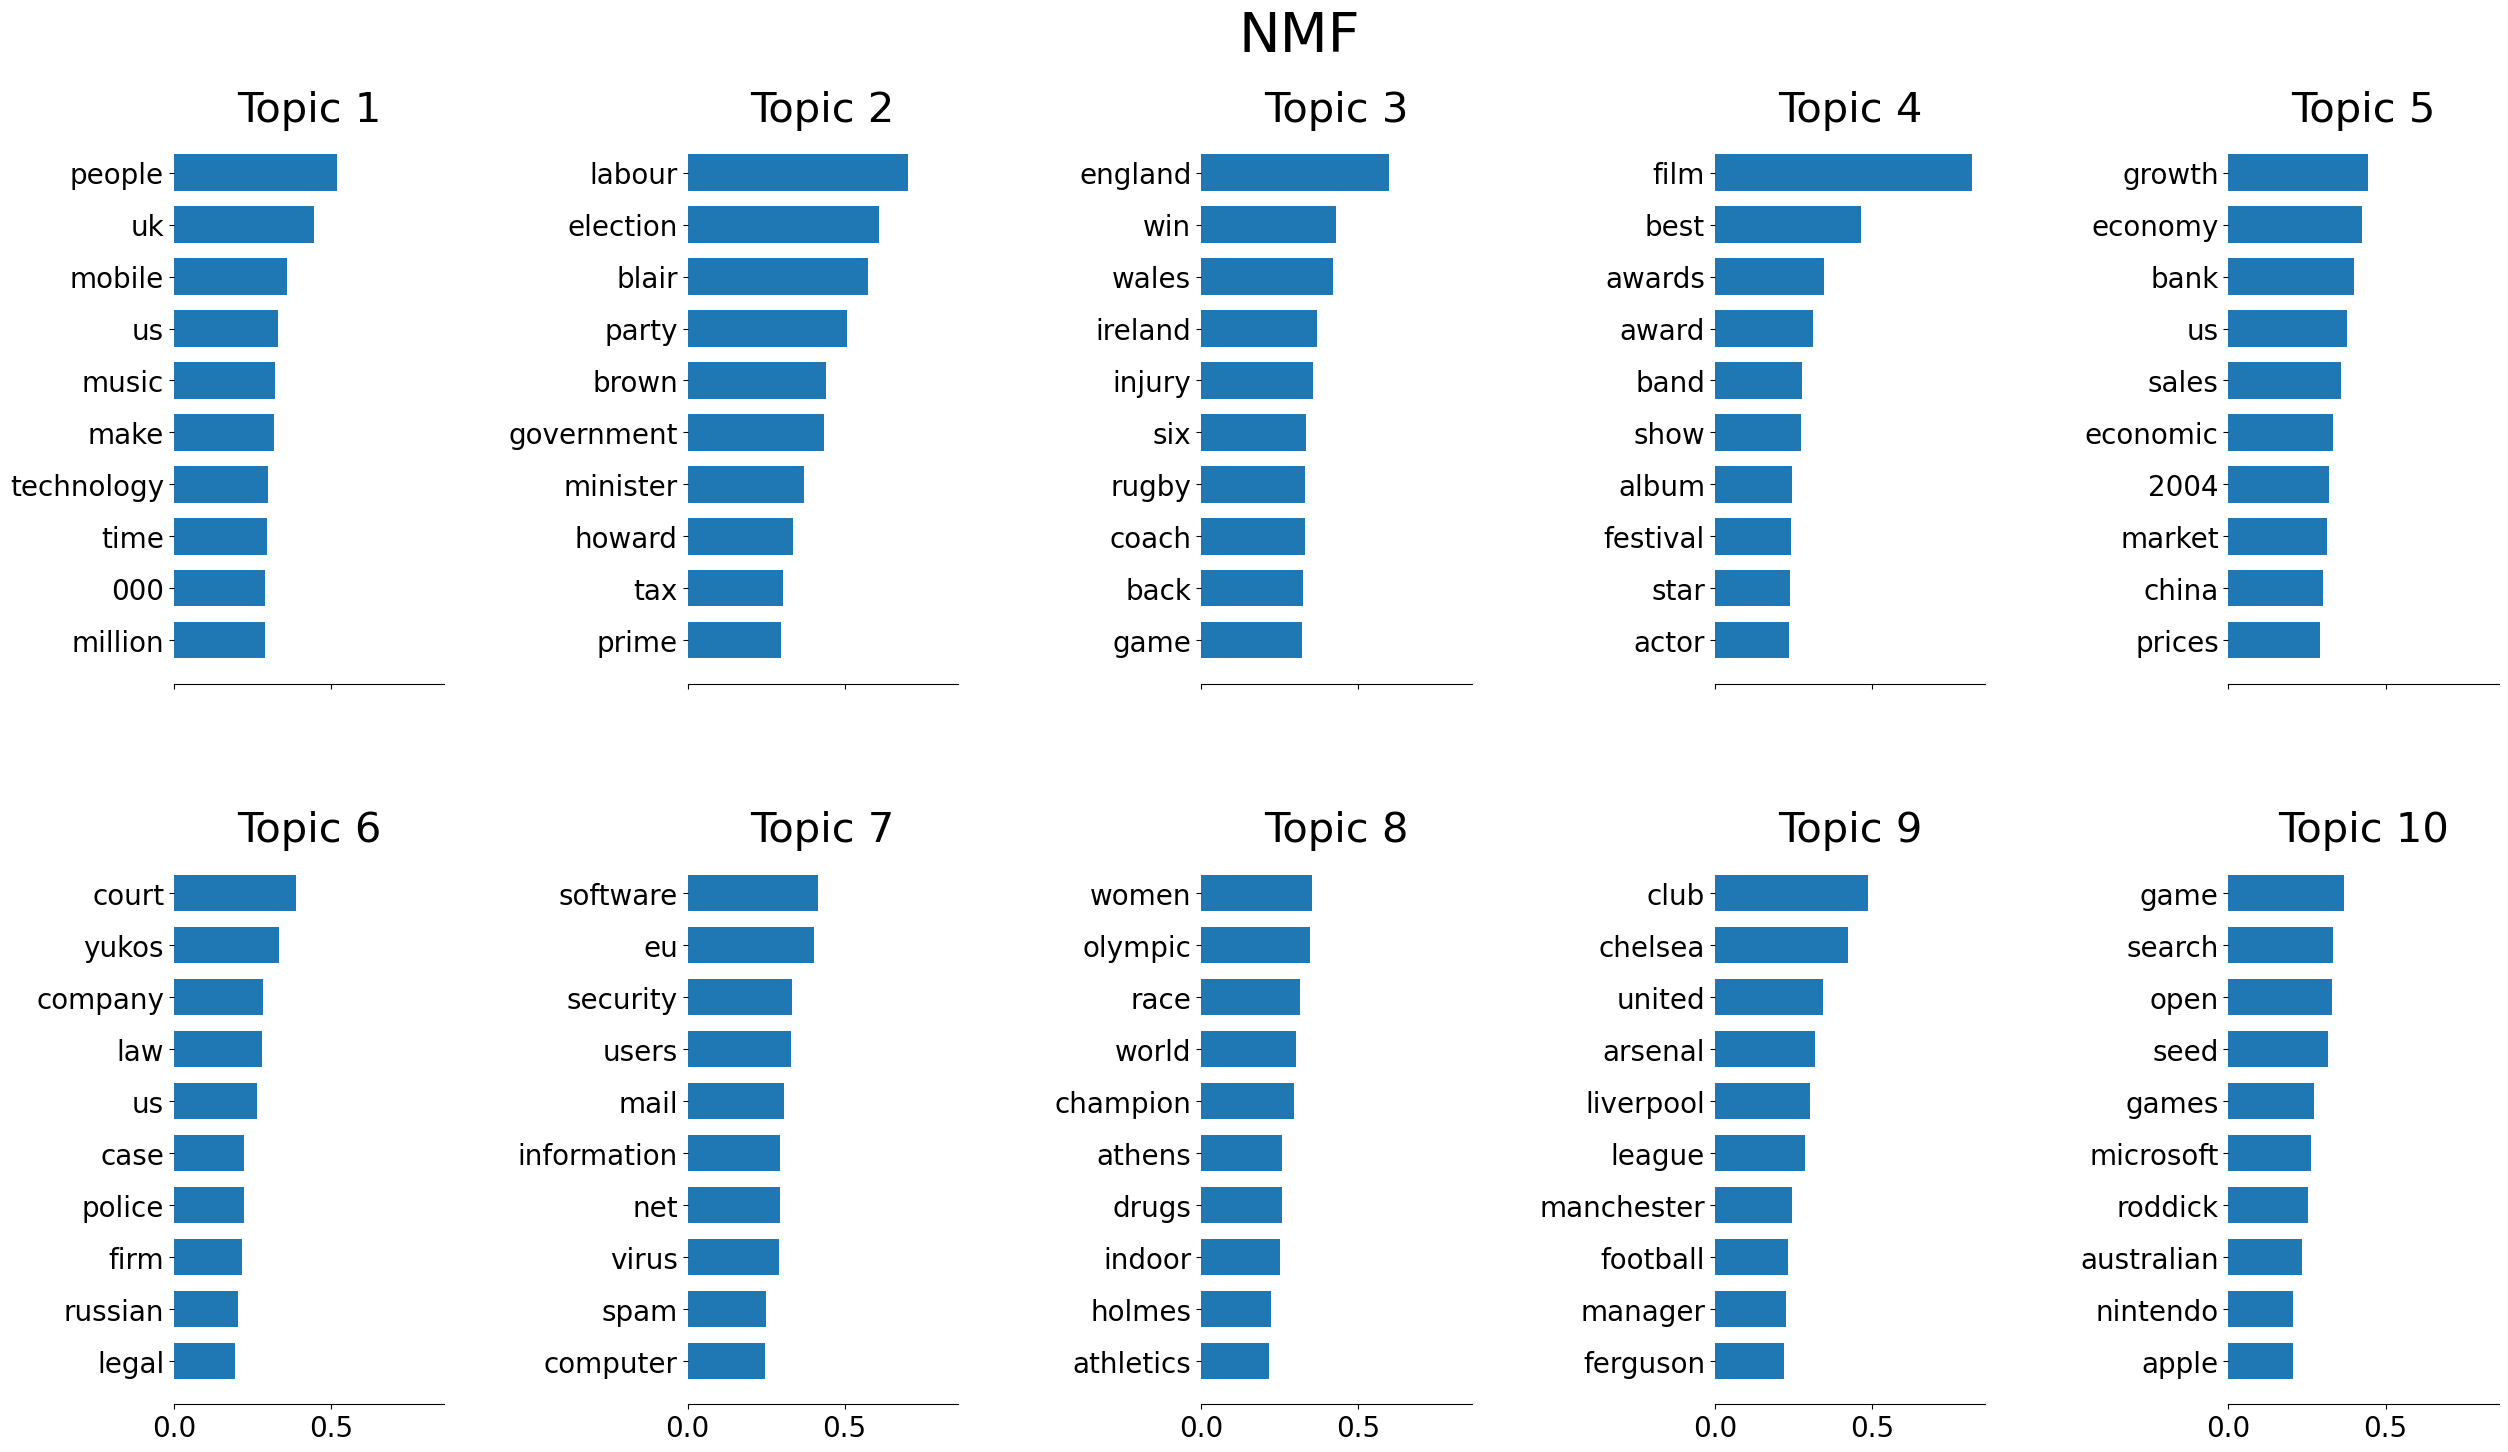

In [10]:
feature_names = vectorizer.get_feature_names_out()
plot_top_words(nmf, feature_names);

In [11]:
Z = nmf.transform(X) ### nmf'te de bu tansform bize documents x topics ü verir

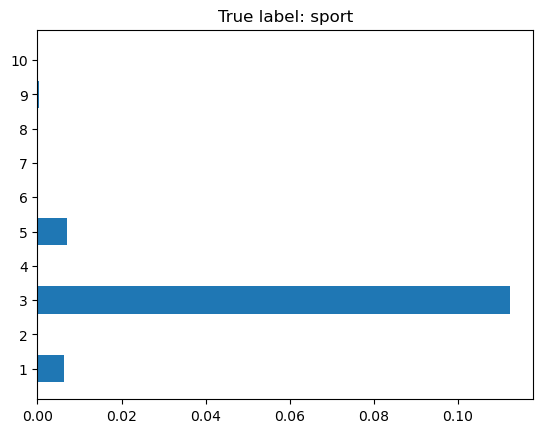

In [12]:
# Pick a random document
# Check which "topics" are associated with it
# Are they related to the true label?

np.random.seed(0)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels']);

#### Note that unlike LDA these values do not sum to 1.

In [13]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

print(wrap(df.iloc[i]['text']))

Charvis set to lose fitness bid

Flanker Colin Charvis is unlikely to
play any part in Wales' final two games of the Six Nations.

Charvis
has missed all three of Wales' victories with an ankle injury and his
recovery has been slower than expected.  "He will not figure in the
Scotland game and is now thought unlikely to be ready for the final
game," said Wales physio Mark Davies.  Sonny Parker is continuing to
struggle with a neck injury, but Hal Luscombe should be fit for the
Murrayfield trip.  Centre Parker has only a "slim chance" of being
involved against the Scots on 13 March, so Luscombe's return to
fitness after missing the France match with hamstring trouble is a
timely boost.

Said Wales assistant coach Scott Johnson: "We're
positive about Hal and hope he'll be raring to go.  "He comes back
into the mix again, adds to the depth and gives us other options.  "
Replacement hooker Robin McBryde remains a doubt after picking up knee
ligament damage in Paris last Saturday.  "We're g

### Summary
- Topic modeling is unsupervised, conceptually similar to clustering
- For LDA a new topic is sampled for every word while for mixture models (clustering), only one topic per document
- NMF derived from recomender system
- NMF can be applied to topic modeling since output is document x topics and topics x words
#### we can also go to reverse direction and apply LDA on recommendation as well